# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [ ]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers','footers','quotes'))
documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [ ]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]' #알파벳 아닌거 다 제거
  text = re.sub(pattern,'',d)
  return text

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd

news_df = pd.DataFrame({'article': documents})
len(news_df)

11314

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.dropna(inplace=True)
print(len(news_df))

11096


In [ ]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [ ]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased what disagree stat...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [ ]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [ ]:
import numpy as np

#drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
#news_texts = np.delete(tokenized_news, drop_news, axis=0)
#print(len(news_texts))

# 이 코드는 tokenized_news에서 문장 길이가 1 이하인 문장을 제거하고자 하는 것. 그러나 오류가 발생하는 이유는 numpy의 배열은 등질적(homogeneous)이어야 하기 때문.
# 즉, 배열의 각 요소는 동일한 유형이어야 합니다. 그러나 여기서는 배열의 각 요소가 리스트인데, 길이가 다른 리스트가 있기 때문에 오류가 발생
# 해결 방법으로는 numpy 배열 대신 파이썬 리스트를 사용하여 문장을 제거하고 새로운 리스트를 생성하는 것. 예를 들어 다음과 같이 코드를 수정

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = [sentence for index, sentence in enumerate(tokenized_news) if index not in drop_news]
print(len(news_texts))

10945


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000) # fit_on_texts 메서드는 텍스트 데이터를 입력으로 받아 토큰화 및 인덱스 생성을 수행. 이 과정을 통해 각 단어에 고유한 정수 인덱스가 할당

idx2word = {value:key for key, value in tokenizer.word_index.items()} # 단어와 그에 해당하는 정수 인덱스를 매핑하는 딕셔너리 idx2word를 생성
sequences = tokenizer.texts_to_sequences(news_2000) # 텍스트 데이터를 정수 시퀀스로 변환

In [ ]:
vocab_size = len(tokenizer.word_index)+1 # +1을 하는 이유는 패딩(padding)을 위한 0을 추가하기 위함입니다. 즉, 단어 인덱스는 1부터 시작하는 반면, 패딩을 위한 인덱스는 0으로 할당
print(vocab_size) # vocab_size는 모델의 입력으로 사용될 수 있는 고유한 단어의 개수

29769


In [ ]:
print(sequences[1])

[1263, 457, 2, 60, 119, 419, 61, 1374, 22, 69, 3498, 397, 6874, 412, 1173, 373, 2256, 458, 59, 12478, 458, 1900, 3850, 397, 22, 10, 4325, 8749, 177, 303, 136, 154, 664, 12479, 316, 12480, 15, 12481, 4, 790, 12482, 12483, 4917, 8750]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling) : Word2Vec 모델에서 소프트맥스 함수를 적용할 때 발생하는 계산량을 줄이기 위한 기법

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation: 신경망의 가중치를 업데이트하기 위해 사용)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams # skip-gram 쌍을 생성

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences[:10]]
# 주어진 텍스트 데이터인 sequences에서 첫 10개의 시퀀스에 대해 skip-gram 쌍을 생성

In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1] # 생성된 첫 번째 skip-gram 쌍의 리스트에서 skip-gram 쌍과 레이블을 추출
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}". format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

acts(1308), israeli(696) -> 1
lived(1011), that(82) -> 1
holocaust(2558), inhuman(8747) -> 1
report(627), think(7) -> 1
reputation(5726), flawless(25072) -> 0


In [ ]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2420
2420


In [ ]:
skip_grams = [skipgrams(seq, vocabulary_size=vocab_size, window_size=10) for seq in sequences] # 10개가 아니라 전체로. vocab_size 거의 3만개

#### Skipgram 모델 구성

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [ ]:
embed_size = 50



---


* 중심 단어와 주변 단어를 입력으로 받아 내적을 계산하고, 확률값으로 출력하여 Word2Vec 모델을 학습

---



In [ ]:
def word2vec():
  # 중심 단어
  target_inputs = Input(shape=(1, ), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  # 주변 단어
  context_inputs = Input(shape=(1, ), dtype = 'int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding]) # target_embedding과 context_embedding의 내적을 계산. 내적 결과는 각 단어의 임베딩 벡터 간의 유사도를 나타냅니다.
  dot_product = Reshape((1, ), input_shape=(1,1))(dot_product) # 내적 결과를 (batch_size, 1) 형태로 변환.
  output = Activation('sigmoid')(dot_product) # sigmoid 활성화 함수를 적용하여 내적 결과를 확률값으로 변환

  model = Model(inputs=[target_inputs, context_inputs], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                1488450   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                1488450   ['input_2[0][0]']             
                                                                                              

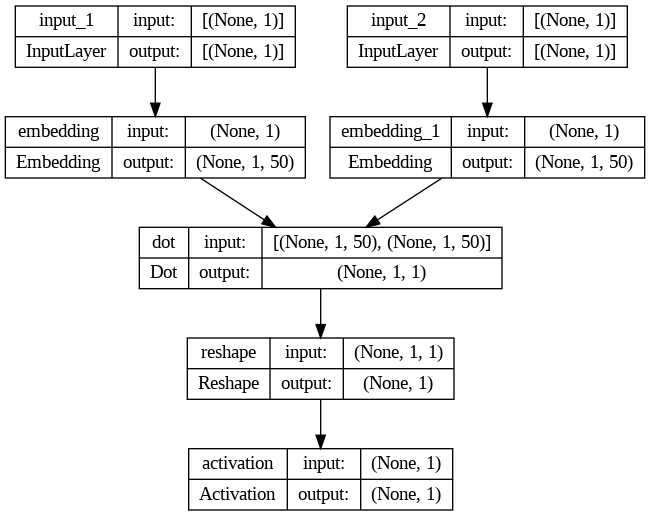

In [ ]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# 주어진 데이터셋을 사용하여 Word2Vec 모델을 학습하는 과정
for epoch in range(1,11):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem] # 학습데이터
        Y = labels # 정답
        loss += model.train_on_batch(X,Y) # 한번의 epoch에 여러 번 트레이닝

    print('Epoch : ', epoch, 'Loss : ', loss)

# 이 코드는 모델을 배치 단위로 훈련하고, 각 에포크가 종료될 때마다 총 손실을 출력하여 모델의 학습 진행 상황을 확인

Epoch :  1 Loss :  1225.9633114784956
Epoch :  2 Loss :  925.1107318997383
Epoch :  3 Loss :  828.4927598983049
Epoch :  4 Loss :  783.6045075133443
Epoch :  5 Loss :  757.5638249590993
Epoch :  6 Loss :  737.7366789020598
Epoch :  7 Loss :  717.7757882252336
Epoch :  8 Loss :  694.336625367403
Epoch :  9 Loss :  666.2634273990989
Epoch :  10 Loss :  633.4126178584993


In [ ]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i,:])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

# 이 코드는 학습된 Word2Vec 모델의 단어 임베딩을 텍스트 파일로 저장하고,
# 이를 Gensim을 사용하여 로드하여 다양한 자연어 처리 작업에 활용할 수 있도록 합니다.
# Gensim을 사용하면 저장된 임베딩을 쉽게 로드하고, 유사도 계산 및 다양한 자연어 처리 작업에 활용

In [ ]:
skipgram.most_similar(positive=['soldier'])

[('traps', 0.8833616971969604),
 ('booby', 0.8431206345558167),
 ('indiscriminately', 0.8426094651222229),
 ('retalliates', 0.8378708958625793),
 ('ammunitions', 0.8202354907989502),
 ('israeli', 0.803903341293335),
 ('occupying', 0.7867326736450195),
 ('sneak', 0.7744042873382568),
 ('pilots', 0.7635866403579712),
 ('patrols', 0.7311012148857117)]

In [ ]:
skipgram.most_similar(positive=['world'])

[('trust', 0.5983980298042297),
 ('assess', 0.5861054062843323),
 ('jerusalem', 0.5756940841674805),
 ('reductions', 0.5705790519714355),
 ('dignity', 0.5681211352348328),
 ('proven', 0.5604243874549866),
 ('norris', 0.5584917068481445),
 ('wish', 0.5571674108505249),
 ('battle', 0.556767463684082),
 ('palastenians', 0.555675208568573)]

### CBOW


#### CBOW 전처리

In [ ]:
# skip-gram 형식의 데이터를 Continuous Bag of Words (CBOW) 형식으로 변환하는 역할
def skipgram2cbow(skipgrams):
  cbows = []
  flag = 0
  for n in skipgrams:
    temp1 = []
    for t in n:
      if flag == 1:
        flag = 0
        temp1.append(t)
      else:
        flag = 1
        temp2 =[]
        for x in t:
          temp2.append([x[1],x[0]])
        temp1.append(temp2)
    cbows.append(temp1)

  return cbows
# CBOW 형식은 중심 단어와 주변 단어 쌍을 나타내는 skip-gram 데이터와는 달리, 주변 단어들을 입력으로 사용하여 중심 단어를 예측하는 방식의 데이터

In [ ]:
cbows = skipgram2cbow(skip_grams)

In [ ]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

arjen(25219), media(499) -> 0
ricktocchet(24359), lived(1011) -> 0
ruin(12474), world(126) -> 1
rediculous(12475), reputation(5726) -> 1
photo(4941), media(499) -> 0


In [ ]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2420
2420


#### CBOW 모델 구성

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 50)                1488450   ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 50)                1488450   ['input_4[0][0]']             
                                                                                            

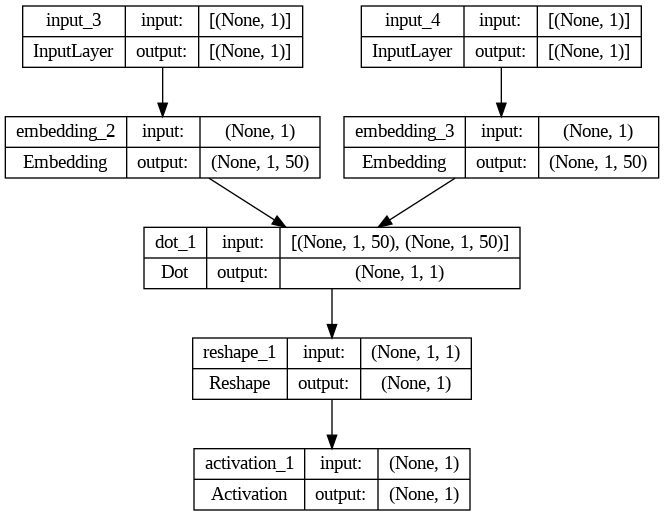

In [ ]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(1,11):
    loss = 0
    for _, elem in enumerate(cbows):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem] # 학습데이터
        Y = labels # 정답
        loss += model.train_on_batch(X,Y) # 한번의 epoch에 여러 번 트레이닝

    print('Epoch : ', epoch, 'Loss : ', loss)

Epoch :  1 Loss :  1225.502495765686
Epoch :  2 Loss :  925.2524921894073
Epoch :  3 Loss :  827.7591038271785
Epoch :  4 Loss :  781.2256288081408
Epoch :  5 Loss :  753.4508342966437
Epoch :  6 Loss :  732.4380545541644
Epoch :  7 Loss :  712.2205487042665
Epoch :  8 Loss :  689.2985857278109
Epoch :  9 Loss :  662.0128354281187
Epoch :  10 Loss :  629.7149579208344


In [ ]:
import gensim

f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word,' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary=False)

In [ ]:
cbow.most_similar(positive=['soldier'])

[('indiscriminately', 0.970798671245575),
 ('traps', 0.9571100473403931),
 ('retalliates', 0.9539009928703308),
 ('pilots', 0.9495633840560913),
 ('booby', 0.9411467909812927),
 ('ammunitions', 0.9331573843955994),
 ('nationality', 0.9224162101745605),
 ('militants', 0.9219769835472107),
 ('alessandro', 0.9214898347854614),
 ('kibbutzim', 0.9203260540962219)]

In [ ]:
cbow.most_similar(positive=['world'])

[('excuse', 0.9457295536994934),
 ('moon', 0.9406962394714355),
 ('doesnt', 0.9346504211425781),
 ('government', 0.9328070282936096),
 ('think', 0.9294689893722534),
 ('area', 0.9291200637817383),
 ('numbers', 0.9286311268806458),
 ('macs', 0.9286293387413025),
 ('dont', 0.9285702109336853),
 ('time', 0.9279574751853943)]